In [3]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
import pyspark.sql.functions as func


spark = SparkSession.builder.appName("nba_stat_analysis_app").getOrCreate()

## Reading data from .csv file

It will be read as data frame.

In [4]:
nba_player_stats = spark.read.csv(path='nba_data.csv',
                         sep=',',
                         encoding='UTF-8',
                         comment=None,
                         header=True,
                         inferSchema=True)

In [5]:
nba_player_stats.show(n=5, truncate=False)


+--------------------+---+---+---+---+----+----+----+----+-----+---+---+-----+----+----+-----+-----+---+---+-----+---+---+----+---+---+---+---+---+----+----+
|Player              |Pos|Age|Tm |G  |GS  |MP  |FG  |FGA |FG%  |3P |3PA|3P%  |2P  |2PA |2P%  |eFG% |FT |FTA|FT%  |ORB|DRB|TRB |AST|STL|BLK|TOV|PF |PTS |Year|
+--------------------+---+---+---+---+----+----+----+----+-----+---+---+-----+----+----+-----+-----+---+---+-----+---+---+----+---+---+---+---+---+----+----+
|Kareem Abdul-Jabbar*|C  |32 |LAL|82 |null|38.3|10.2|16.9|0.604|0.0|0.0|0.0  |10.2|16.9|0.604|0.604|4.4|5.8|0.765|2.3|8.5|10.8|4.5|1.0|3.4|3.6|2.6|24.8|1980|
|Tom Abernethy       |PF |25 |GSW|67 |null|18.2|2.3 |4.7 |0.481|0.0|0.0|0.0  |2.3 |4.7 |0.483|0.481|0.8|1.2|0.683|0.9|1.9|2.9 |1.3|0.5|0.2|0.6|1.8|5.4 |1980|
|Alvan Adams         |C  |25 |PHO|75 |null|28.9|6.2 |11.7|0.531|0.0|0.0|0.0  |6.2 |11.6|0.533|0.531|2.5|3.1|0.797|2.1|6.0|8.1 |4.3|1.4|0.7|2.9|3.2|14.9|1980|
|Tiny Archibald*     |PG |31 |BOS|80 |80  |35.8|4.8 

# Best scorers

Taking players whose average number of points in all seasons is the greates.

In [6]:
top_players_df = nba_player_stats.groupBy('Player') \
                                 .agg({'pts': 'mean'}) \
                                 .withColumnRenamed("avg(pts)", "Average points") \
                                 .orderBy('avg(pts)', ascending=False).show(10)
                                

+------------------+------------------+
|            Player|    Average points|
+------------------+------------------+
|   Michael Jordan*| 29.45333333333333|
|      LeBron James|          27.15625|
|      Kevin Durant| 26.88333333333333|
|       Kobe Bryant|26.082352941176474|
|    Allen Iverson*|26.064285714285713|
|    George Gervin*|25.999999999999996|
|      Karl Malone*|24.689473684210526|
|      James Harden|24.220000000000002|
|Dominique Wilkins*|24.019999999999996|
|   Adrian Dantley*|23.983333333333334|
+------------------+------------------+
only showing top 10 rows



# Average number of 3 points attempts in seasons

The parameter is calculated as average taken over average values of attempts for all players in season.

In [7]:
three_pts_attempts_by_year = nba_player_stats.groupBy('Year') \
                                            .agg(func.mean('3PA')) \
                                            .withColumnRenamed("avg(3PA)", "Average 3PA in year") \
                                            .orderBy('year')

three_pts_attempts_by_year.show(three_pts_attempts_by_year.count())

+----+-------------------+
|Year|Average 3PA in year|
+----+-------------------+
|1980| 0.2473867595818817|
|1981|0.18519736842105294|
|1982|0.20094936708860783|
|1983|0.20189873417721552|
|1984| 0.2112903225806454|
|1985|0.27218749999999986|
|1986| 0.2919999999999998|
|1987| 0.4014925373134323|
|1988|0.42951807228915617|
|1989| 0.5396600566572229|
|1990| 0.5564304461942252|
|1991| 0.6201550387596891|
|1992| 0.6647668393782381|
|1993|  0.754615384615384|
|1994| 0.8148883374689831|
|1995| 1.2904176904176914|
|1996| 1.3701631701631698|
|1997| 1.4018140589569175|
|1998|  1.061275626423691|
|1999| 1.0475000000000003|
|2000|  1.138496583143508|
|2001| 1.1217687074829934|
|2002|             1.2275|
|2003| 1.2028037383177574|
|2004| 1.2314479638009055|
|2005| 1.3163793103448287|
|2006| 1.3041484716157208|
|2007|   1.41288209606987|
|2008|  1.513968957871398|
|2009| 1.5417977528089883|
|2010| 1.5662895927601819|
|2011| 1.5017699115044245|
|2012| 1.5707112970711303|
|2013|  1.663539445628999|
|

# Prediction

Taking years and average values as a list.

In [8]:
three_pts_attempts_by_year.collect()

years = [row['Year'] for row in three_pts_attempts_by_year.collect()]
avg3PA = [row[1] for row in three_pts_attempts_by_year.collect()]

In [9]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Avg 3PA')

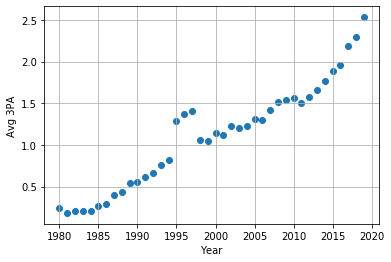

In [10]:
plt.scatter(years, avg3PA)
plt.grid()
plt.xlabel('Year')
plt.ylabel('Avg 3PA')

The plot shows increasing trend, we apply linear regression approach.

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import numpy as np
import pandas as pd

In [12]:
X_train = np.array(years).reshape(-1,1)
Y_train = np.array(avg3PA).reshape(-1,1)

regressor = LinearRegression()  
regressor.fit(X_train, Y_train) #training the algorithm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [13]:
print("Linear regressnion model y = a*x +b")
print("where")
print("a = " + str(regressor.coef_[0][0]))
print("b = " + str(regressor.intercept_[0]))

Linear regressnion model y = a*x +b
where
a = 0.05230548809591704
b = -103.47248776539708


Finding $\hat{y}$ values for training $x$. 

In [14]:
Y_pred = regressor.predict(X_train)

Calculating measures:

In [15]:
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_train, Y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(Y_train, Y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_train, Y_pred)))

Mean Absolute Error: 0.11338813935207251
Mean Squared Error: 0.026193391426463486
Root Mean Squared Error: 0.16184372532311372


We predict values for the next 5 years.

In [16]:
number_of_years_to_predict = 5
x_to_predict = np.arange(X_train[-1]+1, X_train[-1]+1 + number_of_years_to_predict).reshape(-1,1)
y_predicted = regressor.predict(x_to_predict)

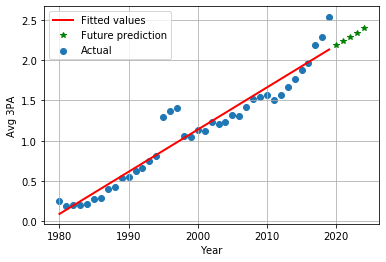

In [17]:

plt.scatter(X_train, Y_train, label='Actual')
plt.plot(X_train, Y_pred, color='red', linewidth=2, label='Fitted values')

plt.plot(x_to_predict, y_predicted, 'g*', label='Future prediction')
plt.grid()
plt.xlabel('Year')
plt.ylabel('Avg 3PA')
plt.legend()
plt.show()

The plot shows how the linear regression line fit to the data.

In [18]:
df_predicted = pd.DataFrame({'Year': x_to_predict.flatten(), 'Predicted Avg 3PE': y_predicted.flatten()})
df_predicted

,Year,Predicted Avg 3PE
0,2020,2.184598
1,2021,2.236904
2,2022,2.289209
3,2023,2.341515
4,2024,2.393820


We see that predicted values are lower then in the recent years. We construct model basing on precvious ten years.

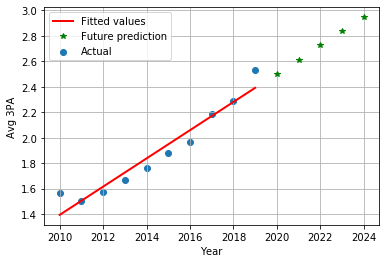

In [19]:
X_train = np.array(years[-10:]).reshape(-1,1)
Y_train = np.array(avg3PA[-10:]).reshape(-1,1)

regressor_2 = LinearRegression()  
regressor_2.fit(X_train, Y_train) 

Y_pred = regressor_2.predict(X_train)
Y_future_predicted = regressor_2.predict(x_to_predict)

plt.scatter(X_train, Y_train, label='Actual')
plt.plot(X_train, Y_pred, color='red', linewidth=2, label='Fitted values')

plt.plot(x_to_predict, Y_future_predicted, 'g*', label='Future prediction')
plt.grid()
plt.xlabel('Year')
plt.ylabel('Avg 3PA')
plt.legend()
plt.show()

In [20]:
df_predicted_2 = pd.DataFrame({'Year': x_to_predict.flatten(), 'Predicted Avg 3PE': Y_future_predicted.flatten()})
df_predicted_2

,Year,Predicted Avg 3PE
0,2020,2.501628
1,2021,2.612495
2,2022,2.723361
3,2023,2.834228
4,2024,2.945094


In that case the predicted values are greater than whne all years was taken into account. That prediction seems to be more accurate.